In [55]:

import torch.nn as nn
import torch.nn.functional as F
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter
from PIL import Image
import math

In [60]:
#对训练集做数据归一化及增强处理
TRAINING_DIR="./rps/train/"
# 定义图像预处理和增强
def remove_alpha_channel(image):
    if image.mode == 'RGBA':
        return image.convert('RGB')
    else:
        return image
transform = transforms.Compose([
    transforms.Lambda(remove_alpha_channel), # 去除Alpha通道
    transforms.Resize((256, 256)),  # 调整图像大小
    transforms.RandomHorizontalFlip(),  # 随机水平翻转
    transforms.RandomRotation(40),  # 随机旋转
    transforms.RandomAffine(degrees=0,
                            translate=(0.2, 0.2),
                            shear=0.2,
                            scale=(0.8, 1.2)),  # 随机仿射变换，包括平移、剪切、缩放
    transforms.ToTensor(),  # 将图像转换为Tensor
    transforms.Normalize([1. / 255, 1. / 255, 1. / 255],
                         [1, 1, 1])  # 对每个通道进行归一化，均值为1/255，标准差为1
])
TRAINING_DIR="./rps/train/"
train_dataset = datasets.ImageFolder(TRAINING_DIR, transform=transform)

# 创建数据加载器
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

#对验证集做数据归一化处理
VALIDATION_DIR="./rps/val/"
# 定义验证集的图像预处理
validation_transform = transforms.Compose([
    transforms.Lambda(remove_alpha_channel), # 去除Alpha通道
    transforms.Resize((256, 256)),  # 调整图像大小
    transforms.ToTensor(),  # 将图像转换为Tensor
    transforms.Normalize([1. / 255, 1. / 255, 1. / 255],
                         [1, 1, 1])  # 对每个通道进行归一化
])
VALIDATION_DIR="./rps/val/"
validation_dataset = datasets.ImageFolder(VALIDATION_DIR, transform=validation_transform)

# 创建验证集的数据加载器
validation_loader = DataLoader(validation_dataset,
                               batch_size=32,
                               shuffle=False)

In [69]:
class PatchEmbedding(nn.Module):
    def __init__(self, in_channels, patch_size, embed_dim, num_patches, dropout):
        super(PatchEmbedding, self).__init__()
        self.patcher = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=embed_dim, kernel_size=patch_size, stride=patch_size),
            nn.Flatten(2)
        )

        self.cls_token = nn.Parameter(torch.randn(size=(1, 1, embed_dim)), requires_grad=True)
        self.position_embedding = nn.Parameter(torch.randn(size=(1, num_patches+1, embed_dim)), requires_grad=True)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x):
        cls_token = self.cls_token.expand(x.shape[0], -1, -1)

        x = self.patcher(x).permute(0, 2, 1)
        x = torch.cat([cls_token, x], dim=1)
        x = x + self.position_embedding
        x = self.dropout(x)
        return x


class RPSTrans(nn.Module):
    def __init__(self, in_channels, patch_size, embed_dim, num_patches, dropout,
                 num_heads, activation, num_encoders, num_classes):
        super(RPSTrans, self).__init__()
        self.patch_embedding = PatchEmbedding(in_channels, patch_size, embed_dim, num_patches, dropout)
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, dropout=dropout,
                                                   activation=activation,
                                                   batch_first=True, norm_first=True)
        self.encoder_blocks = nn.TransformerEncoder(encoder_layer, num_layers=num_encoders)
        self.MLP = nn.Sequential(
            nn.LayerNorm(normalized_shape=embed_dim),
            nn.Linear(in_features=embed_dim, out_features=num_classes)
        )

    def forward(self, x):
        x = self.patch_embedding(x)
        x = self.encoder_blocks(x)
        x = self.MLP(x[:, 0, :])
        return x

In [71]:
IMG_SIZE = 256
IN_CHANNELS = 3
PATCH_SIZE = 16
NUM_PATCHES = (IMG_SIZE // PATCH_SIZE) ** 2 
EMBED_DIM = (PATCH_SIZE ** 2) * IN_CHANNELS  
DROPOUT = 0.001

NUM_HEADS = 8
ACTIVATION = "gelu"
NUM_ENCODERS = 4
NUM_CLASSES = 3

device = "cuda" if torch.cuda.is_available() else "cpu"

model = RPSTrans(IN_CHANNELS, PATCH_SIZE, EMBED_DIM, NUM_PATCHES, DROPOUT, NUM_HEADS, ACTIVATION, NUM_ENCODERS,
            NUM_CLASSES).to(device)
x = torch.randn(size=(1, 3, 256, 256)).to(device)
prediction = model(x)
print(prediction.shape)

torch.Size([1, 3])


In [72]:

# 检查CUDA是否可用，据此设置设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = model.to(device)  # 将模型移动到指定的设备上

In [73]:
# 定义损失函数和优化器
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),  lr=1e-4)

# 训练网络模型
def train_model(model, train_loader, validation_loader, epochs):
    writer = SummaryWriter('./runs/rps_trans_log')  # 初始化SummaryWriter
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        epoch_loss = 0.0
        with tqdm(total=len(train_loader),
                  ncols=150,
                  desc=f"epoch:{epoch+1}/{epochs}") as pBar:
            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = loss_function(outputs, labels)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()
                pBar.update()
                pBar.set_description(
                    f"epoch:{epoch+1}/{epochs}|running_loss:{loss.item()/len(inputs)}"
                )
            epoch_loss = running_loss / len(train_loader) / 32
            pBar.set_description(
                f"epoch:{epoch+1}/{epochs}|epch_loss:{epoch_loss}")
        writer.add_scalar('Loss/Training', epoch_loss, epoch)  # 记录训练损失
        # 验证阶段
        model.eval()
        total = 0
        correct = 0
        acc = 0.0
        best_acc = 0.0
        with torch.no_grad(), tqdm(total=len(validation_loader),
                                   ncols=150,
                                   desc=f"validate:{epoch+1}/{epochs}") as pBar:
            for inputs, labels in validation_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                pBar.update()
            acc = 100 * correct / total
            if acc > best_acc:
                best_acc = acc
                torch.save(model.state_dict(), "./weight/best_rpsTrans.pth")
            pBar.set_description(f"validate:{epoch+1}/{epochs}|acc:{acc:.2f}")
        writer.add_scalar('Validation Accuracy', acc, epoch)  # 记录验证准确率

# 假设 train_loader 和 validation_loader 已经定义
train_model(model, train_loader, validation_loader, epochs=10)

# 保存模型
torch.save(model.state_dict(), "./weight/rpsTrans.pth")

epoch:1/10|epch_loss:0.03721523138729832: 100%|███████████████████████████████████████████████████████████████████████| 79/79 [00:16<00:00,  4.72it/s]
validate:1/10|acc:34.68: 100%|████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  9.24it/s]
epoch:2/10|epch_loss:0.03506457767909086: 100%|███████████████████████████████████████████████████████████████████████| 79/79 [00:15<00:00,  5.10it/s]
validate:2/10|acc:54.30: 100%|████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  9.77it/s]
epoch:3/10|epch_loss:0.03432267083774639: 100%|███████████████████████████████████████████████████████████████████████| 79/79 [00:15<00:00,  4.95it/s]
validate:3/10|acc:33.33: 100%|████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  7.16it/s]
epoch:4/10|epch_loss:0.033963955915238285: 100%|██████████████████████████████████████████████

In [66]:
model.load_state_dict(torch.load("./weight/best_rpsTrans.pth"))
total = 0
correct = 0
acc = 0.0
best_acc = 0.0
with torch.no_grad(), tqdm(total=len(train_loader),
                            ncols=150,
                            desc=f"validate:") as pBar:
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        pBar.update()
    acc = 100 * correct / total
    if acc > best_acc:
        best_acc = acc
    pBar.set_description(f"validate:|acc:{acc:.2f}")

validate:|acc:49.96: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:09<00:00,  8.40it/s]


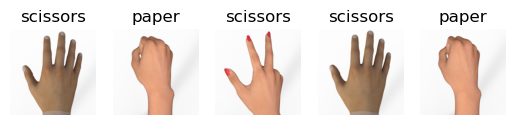

In [77]:
IMG_SIZE = 256
IN_CHANNELS = 3
PATCH_SIZE = 16
NUM_PATCHES = (IMG_SIZE // PATCH_SIZE) ** 2 
EMBED_DIM = (PATCH_SIZE ** 2) * IN_CHANNELS  
DROPOUT = 0.001

NUM_HEADS = 8
ACTIVATION = "gelu"
NUM_ENCODERS = 4
NUM_CLASSES = 3

device = "cuda" if torch.cuda.is_available() else "cpu"

model = RPSTrans(IN_CHANNELS, PATCH_SIZE, EMBED_DIM, NUM_PATCHES, DROPOUT, NUM_HEADS, ACTIVATION, NUM_ENCODERS,
            NUM_CLASSES).to(device)
model.load_state_dict(torch.load("./weight/best_rpsTrans.pth"))
model = model.to(device)
model.eval()


test_transform = transforms.Compose([
    transforms.Lambda(remove_alpha_channel), # 去除Alpha通道
    transforms.Resize((256, 256)),  # 调整图像大小
    transforms.ToTensor(),  # 将图像转换为Tensor
    transforms.Normalize([1. / 255, 1. / 255, 1. / 255],
                         [1, 1, 1])  # 对每个通道进行归一化
])
# 对单张图像进行预测
def predict_image(model, image_path):
    image = Image.open(image_path)
    image = test_transform(image).to(device)
    image = image.unsqueeze(0)
    output = model(image)
    _, predicted = torch.max(output.data, 1)
    return predicted.item()


label_map = {0: "paper", 1: "rock", 2: "scissors"}
for i in range(5):
    plt.subplot(1, 5, i + 1)
    image_path = f"./rps/test/{i+1}.png"
    img=mpimg.imread(f"./rps/test/{i+1}.png")
    plt.imshow(img)
    plt.title(label_map[predict_image(model, image_path)])
    plt.axis('Off')
plt.show()